In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os

from mingpt.utils import set_seed
from mingpt.trainer import Trainer, PrefixTrainer
from mingpt.model import GPT
from mingpt.data_tools import CustomDataset, eval, batch_end_callback, attention_visualization, label_batch

import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List

set_seed(1428)

We saw that prefix-tuning cannot learn a new task.
However, we hypothesize that if the model has been pre-trained on various tasks, prefix-tuning can elucidate one of them.
In this notebook we demonstrate that this is the case.
We will pre-train a model on four different tasks: sort in ascending and descending order, or add one or two to each element of the list.
The model will recieve no indication of which task it needs to solve so it will learn to put approximately equal probability on all 4 completions, resulting in about 25% accuracyt.
However, by learning prefixes, we can constrain the output distribution to only one of the tasks, thus demonstrating that while prefix-tuning cannot learn a completely new task, it can specialize a model to one of the tasks it has already seen.

First let's prepare our datasets:

In [2]:
prefix_size = 1
train_dataset_random = CustomDataset('train', mode="random", prefix_padding=prefix_size)
train_dataset_ascending = CustomDataset('train', mode="ascending", prefix_padding=prefix_size)
train_dataset_descending = CustomDataset('train', mode="descending", prefix_padding=prefix_size)
train_dataset_add1 = CustomDataset('train', mode="add1", prefix_padding=prefix_size)
train_dataset_add2 = CustomDataset('train', mode="add2", prefix_padding=prefix_size)

test_dataset_random = CustomDataset('test', mode="random", prefix_padding=prefix_size)
test_dataset_ascending = CustomDataset('test', mode="ascending", prefix_padding=prefix_size)
test_dataset_descending = CustomDataset('test', mode="descending", prefix_padding=prefix_size)
test_dataset_add1 = CustomDataset('test', mode="add1", prefix_padding=prefix_size)
test_dataset_add2 = CustomDataset('test', mode="add2", prefix_padding=prefix_size)

Let's pre-train the model on `train_dataset_random` and check its accuracy:

In [3]:
# create a GPT instance
model_config = GPT.get_default_config()
model_config.model_type = None
model_config.vocab_size = train_dataset_random.get_vocab_size()
model_config.block_size = train_dataset_random.get_block_size()
model_config.n_layer = 1
model_config.n_head = 4
model_config.n_embd = 256
model_config.skip_layer_norm = True
model = GPT(model_config)

fname = '02_pretrained.pth'
if os.path.exists(fname):
    print("Loading weights from cache, won't train from scratch.")
    model.load_state_dict(torch.load(fname))
    model.config = model_config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
else:
    # create a Trainer object
    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-4
    train_config.max_iters = 20000
    train_config.num_workers = 0
    trainer = Trainer(train_config, model, train_dataset_random)
    trainer.set_callback('on_batch_end', batch_end_callback)
    trainer.run()
    device = trainer.device

    # save the model weights:
    torch.save(model.state_dict(), fname)

number of parameters: 0.93M
Loading weights from cache, won't train from scratch.


In [4]:
print("Performance on a randomly labeled dataset:")
_ = eval(model, dataset=test_dataset_random, device=device, max_batches=32)
print("Performance on the ascending dataset:")
_ = eval(model, dataset=test_dataset_ascending, device=device, max_batches=32)
print("Performance on the descending dataset:")
_ = eval(model, dataset=test_dataset_descending, device=device, max_batches=32)
print("Performance on the add1 dataset:")
_ = eval(model, dataset=test_dataset_add1, device=device, max_batches=32)
print("Performance on the add2 dataset:")
_ = eval(model, dataset=test_dataset_add2, device=device, max_batches=32)

Performance on a randomly labeled dataset:
Final score: 754/3200 = 23.56% correct
Performance on the ascending dataset:
Final score: 1045/3200 = 32.66% correct
Performance on the descending dataset:
Final score: 572/3200 = 17.88% correct
Performance on the add1 dataset:
Final score: 953/3200 = 29.78% correct
Performance on the add2 dataset:
Final score: 516/3200 = 16.12% correct


As there is randomness involved, the model might not have 25% accuracy for all tasks, but it still does have about 25% accuracy overall.

Let's train a separate prefix for each task now:

In [5]:
prefixes = dict()

for task, iterations, lr in zip(
    ["ascending", "descending", "add1", "add2"],
    [30_000, 30_000, 30_000, 30_000],
    [5e-5, 5e-5, 5e-5, 5e-5]
):
    fname = f'02_prefix_{task}.pth'
    if os.path.exists(fname):
        prefixes[task] = torch.load(fname)
        print(f"Prefix {task} loaded from cache.")
    else:
        print(f"TRAINING A PREFIX FOR THE {task.upper()} TASK:")
        prefixes[task]  = torch.randn((model.config.n_layer,prefix_size, model.config.n_embd), requires_grad=True, device=device)
        train_config = Trainer.get_default_config()
        train_config.num_workers = 0
        train_config.max_iters = iterations
        train_config.learning_rate = lr
        trainer = PrefixTrainer(train_config, model, locals()[f"train_dataset_{task}"], prefixes[task])
        trainer.set_callback('on_batch_end', batch_end_callback)
        trainer.run()
        torch.save(prefixes[task], fname)
    _ = eval(model, dataset=locals()[f"test_dataset_{task}"], device=device, max_batches=32, prefixes=prefixes[task])
    print()


TRAINING A PREFIX FOR THE ASCENDING TASK:
running on device cuda
iter_dt   2.74ms; iter   1000: train loss 0.18309
iter_dt   2.69ms; iter   2000: train loss 0.14864
iter_dt   2.66ms; iter   3000: train loss 0.13508
iter_dt   2.76ms; iter   4000: train loss 0.11174
iter_dt   2.68ms; iter   5000: train loss 0.09049
iter_dt   2.73ms; iter   6000: train loss 0.09376
iter_dt   2.60ms; iter   7000: train loss 0.09943
iter_dt   2.66ms; iter   8000: train loss 0.09198
iter_dt   2.63ms; iter   9000: train loss 0.07315
iter_dt   2.63ms; iter  10000: train loss 0.07260
iter_dt   2.66ms; iter  11000: train loss 0.06786
iter_dt   2.80ms; iter  12000: train loss 0.08312
iter_dt   2.65ms; iter  13000: train loss 0.06360
iter_dt   2.53ms; iter  14000: train loss 0.08200
iter_dt   2.58ms; iter  15000: train loss 0.06906
iter_dt   2.77ms; iter  16000: train loss 0.07461
iter_dt   2.74ms; iter  17000: train loss 0.06341
iter_dt   2.67ms; iter  18000: train loss 0.06409
iter_dt   2.86ms; iter  19000: trai

In [6]:
# Print a matrix of accuracies on all tasks for all prefixes:
for prefix_task in [None, "ascending", "descending", "add1", "add2"]:
    print(f"Prefix {prefix_task}:")
    for test_task in ["ascending", "descending", "add1", "add2"]:
        print(f"- Task {test_task} ", end="")
        _ = eval(model, dataset=locals()[f"test_dataset_{test_task}"], device=device, max_batches=32, prefixes=prefixes[prefix_task] if prefix_task is not None else None)

Prefix None:
- Task ascending Final score: 1006/3200 = 31.44% correct
- Task descending Final score: 613/3200 = 19.16% correct
- Task add1 Final score: 959/3200 = 29.97% correct
- Task add2 Final score: 500/3200 = 15.62% correct
Prefix ascending:
- Task ascending Final score: 3011/3200 = 94.09% correct
- Task descending Final score: 0/3200 = 0.00% correct
- Task add1 Final score: 0/3200 = 0.00% correct
- Task add2 Final score: 0/3200 = 0.00% correct
Prefix descending:
- Task ascending Final score: 1/3200 = 0.03% correct
- Task descending Final score: 2679/3200 = 83.72% correct
- Task add1 Final score: 7/3200 = 0.22% correct
- Task add2 Final score: 21/3200 = 0.66% correct
Prefix add1:
- Task ascending Final score: 0/3200 = 0.00% correct
- Task descending Final score: 0/3200 = 0.00% correct
- Task add1 Final score: 3188/3200 = 99.62% correct
- Task add2 Final score: 0/3200 = 0.00% correct
Prefix add2:
- Task ascending Final score: 0/3200 = 0.00% correct
- Task descending Final score: 0/

With the task-specific prefixes, the accuracy gets close to 100% for all four tasks.
Therefore, we successfully found prefixes that steer the behavior of the pre-trained model towards only one of the four possible completions.

We can also take a look at the attention.

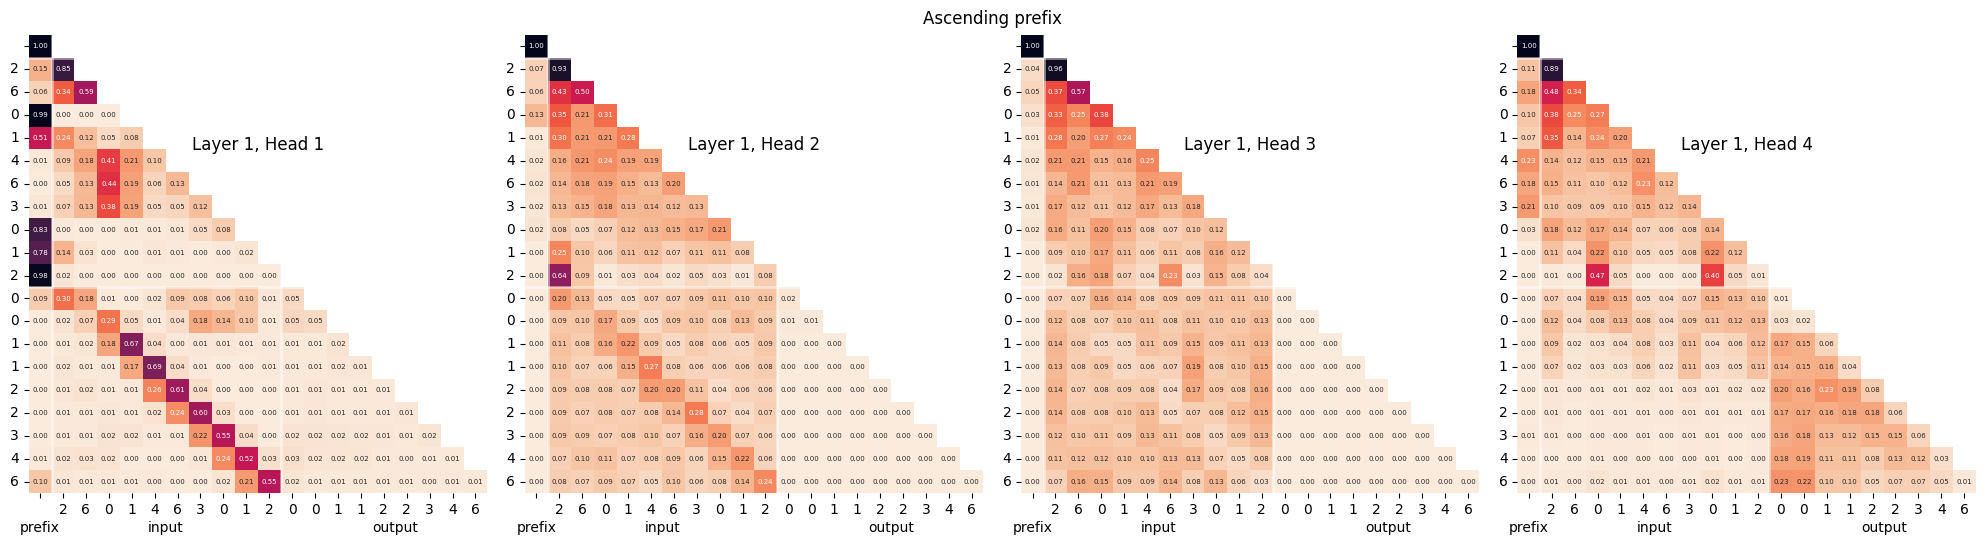

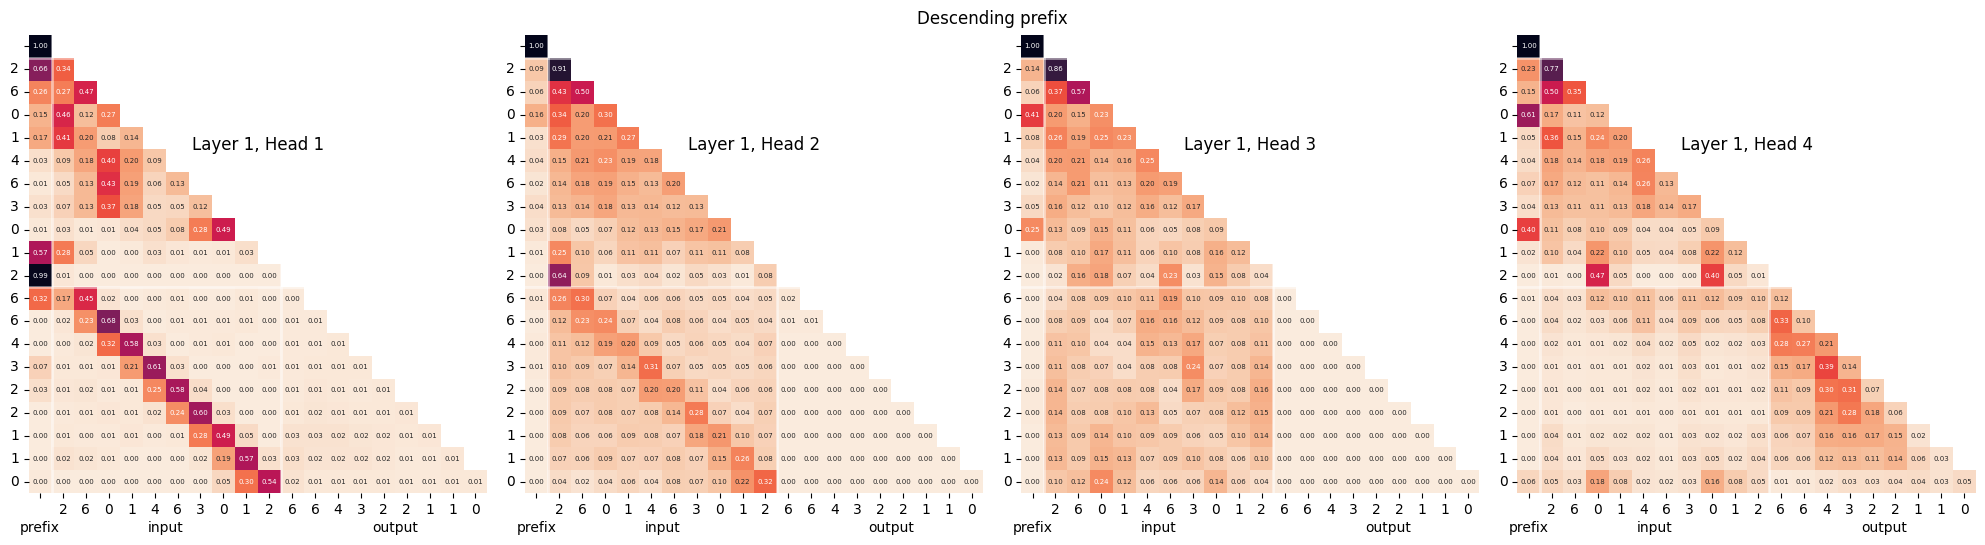

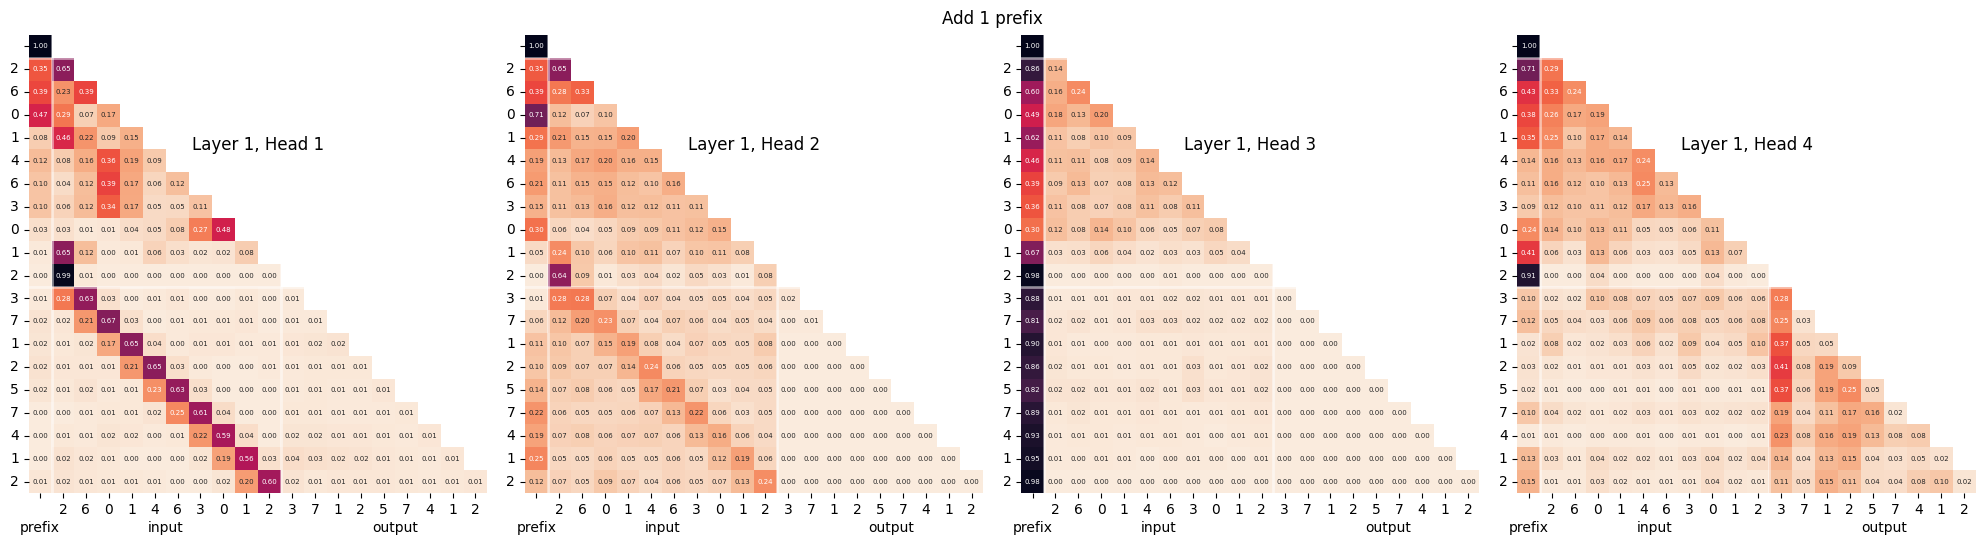

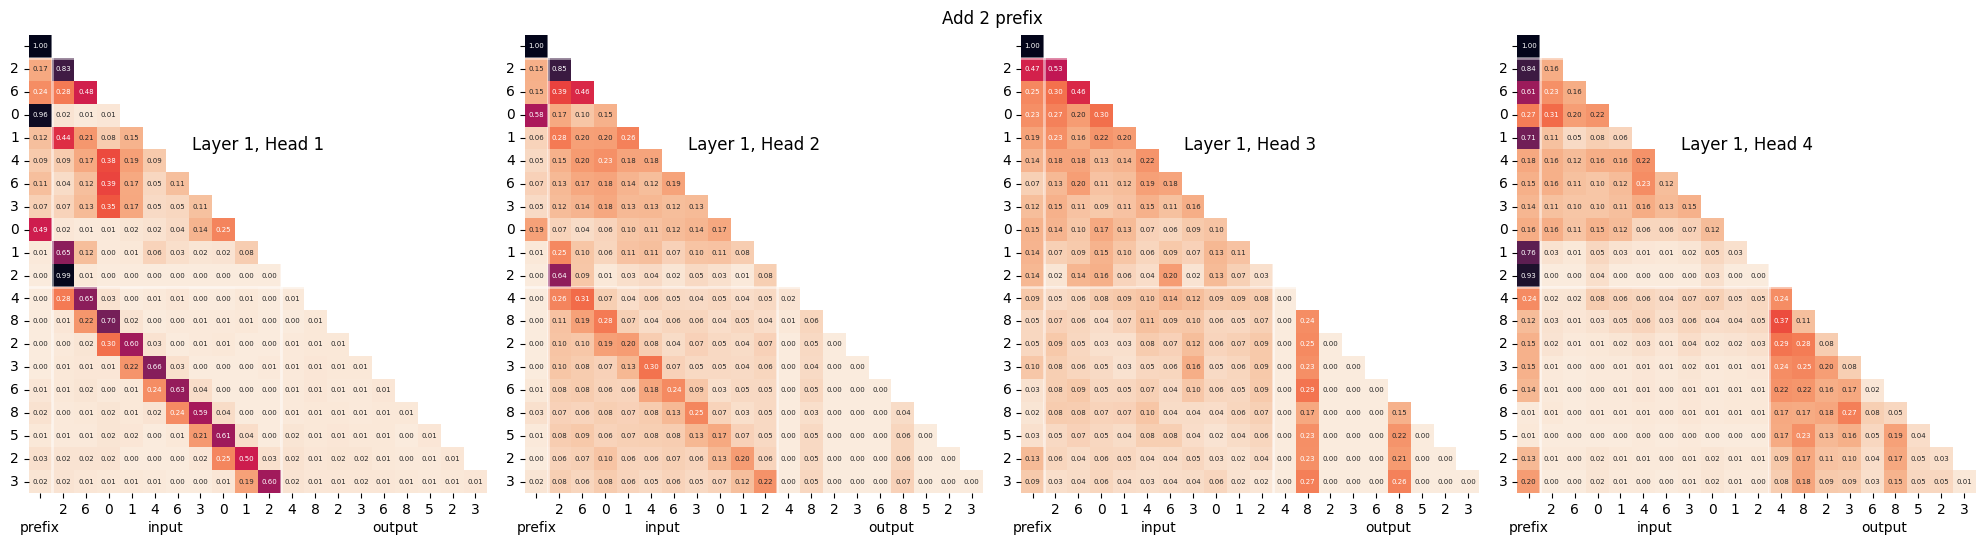

In [7]:
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["ascending"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Ascending prefix")
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["descending"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Descending prefix")
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["add1"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Add 1 prefix")
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["add2"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Add 2 prefix")

In the above, the attentions might at first seem very different for the different prefixes, seemingly at odds with our theory.
However, that is because the different prefixes capture different amount of attention from the content positions (`input` and `output`).
This is in line with our theory: the relative distribution of attention across the content positions has to stay the same but the values will all be scaled down by an equal factor equal to 1 minus the attention on the prefix.

To verify that this is the case, here is the same plot but with the attention on the prefix removed.
Note how the attention pattern of the `input` positions is the same regardless of the prefix (or lack thereof).
The attention pattern of the `output` positions is different but that is expected: this is caused by the fact that the completions are different.

The pre-trained model will likely output the same `output` as one of the prefixed models.
If you compare the attention patterns of these two, they would be identical: precisely in line with out theory!

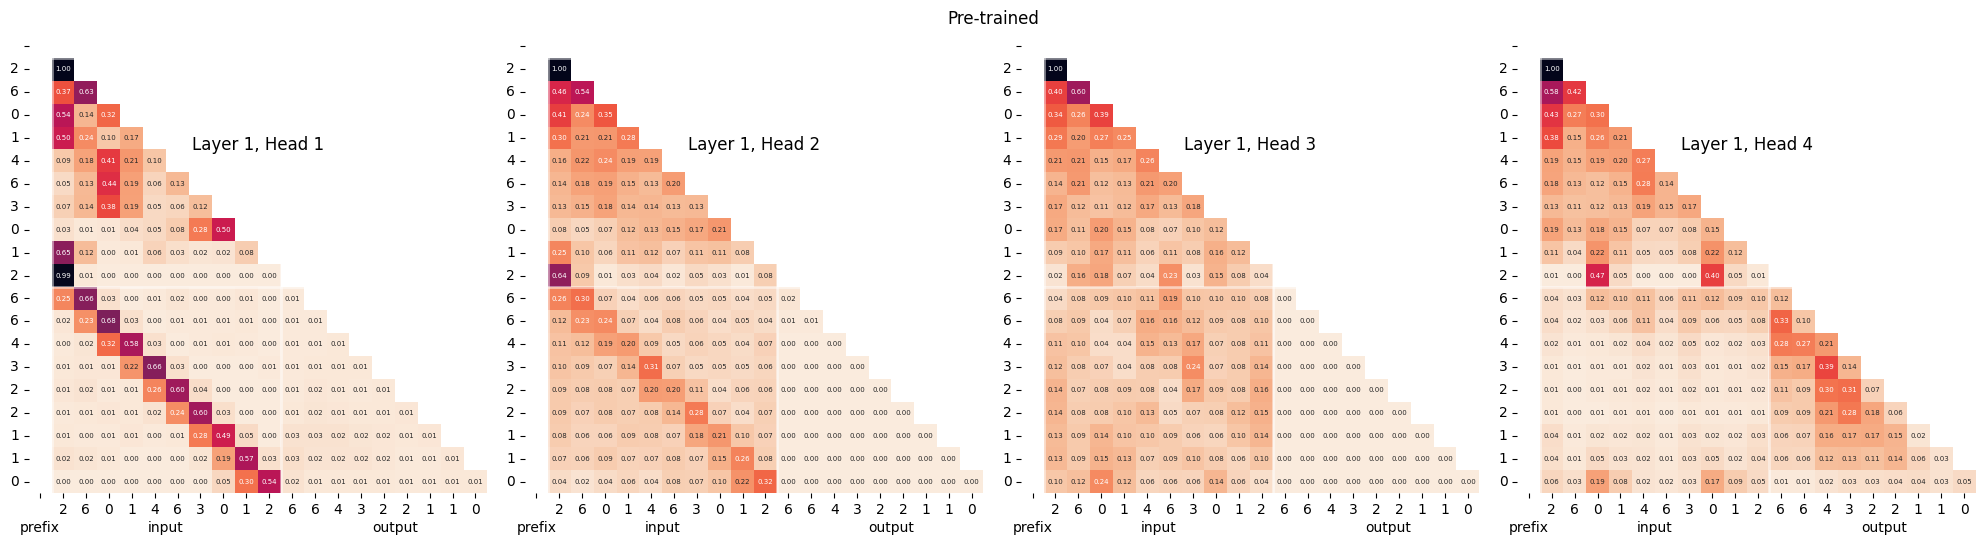

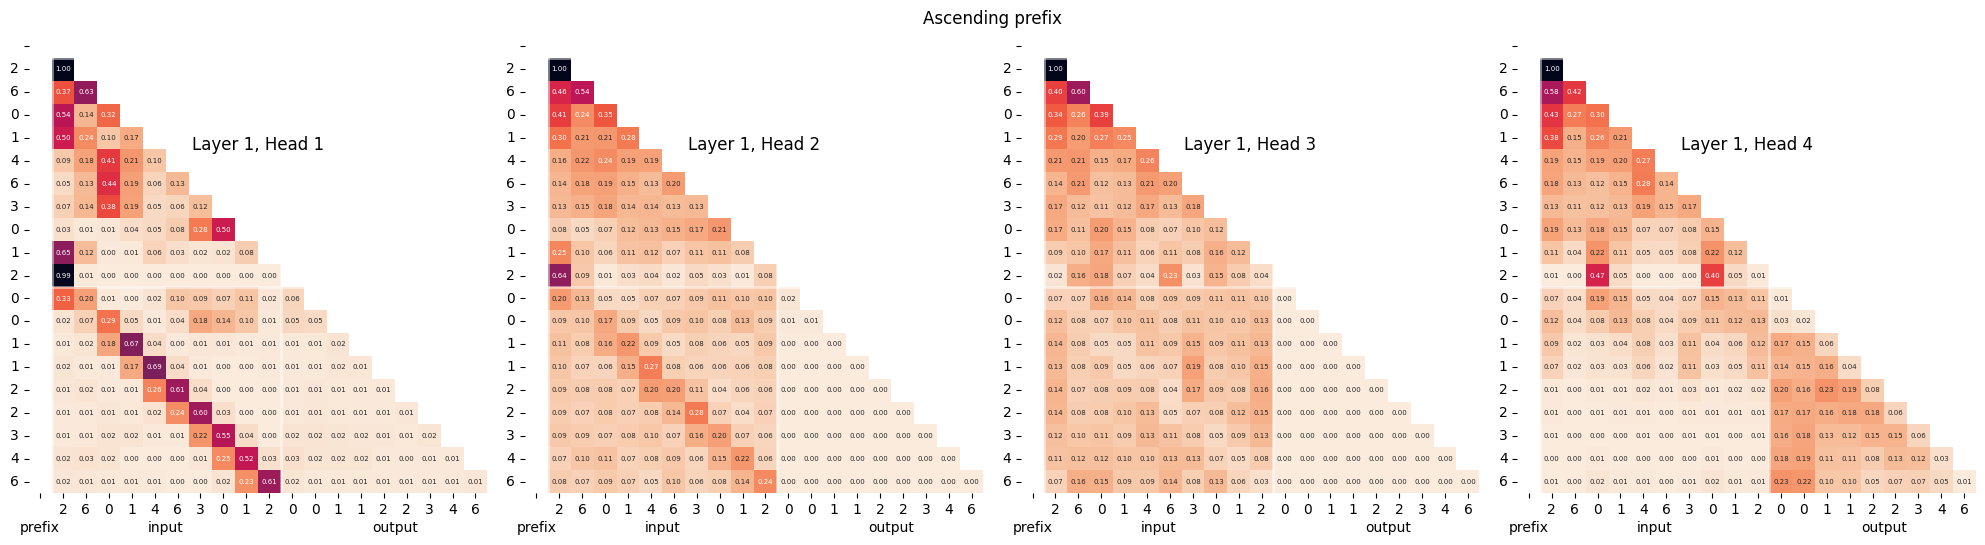

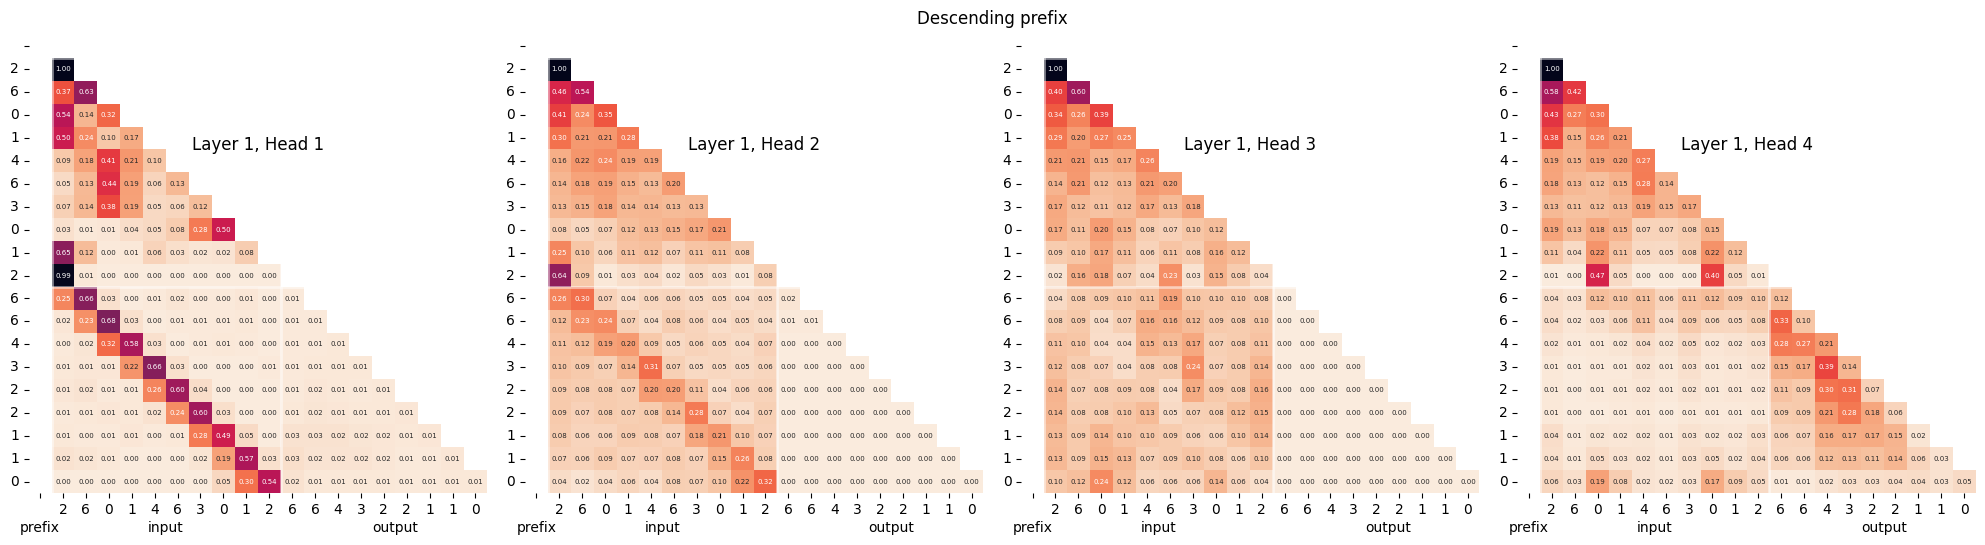

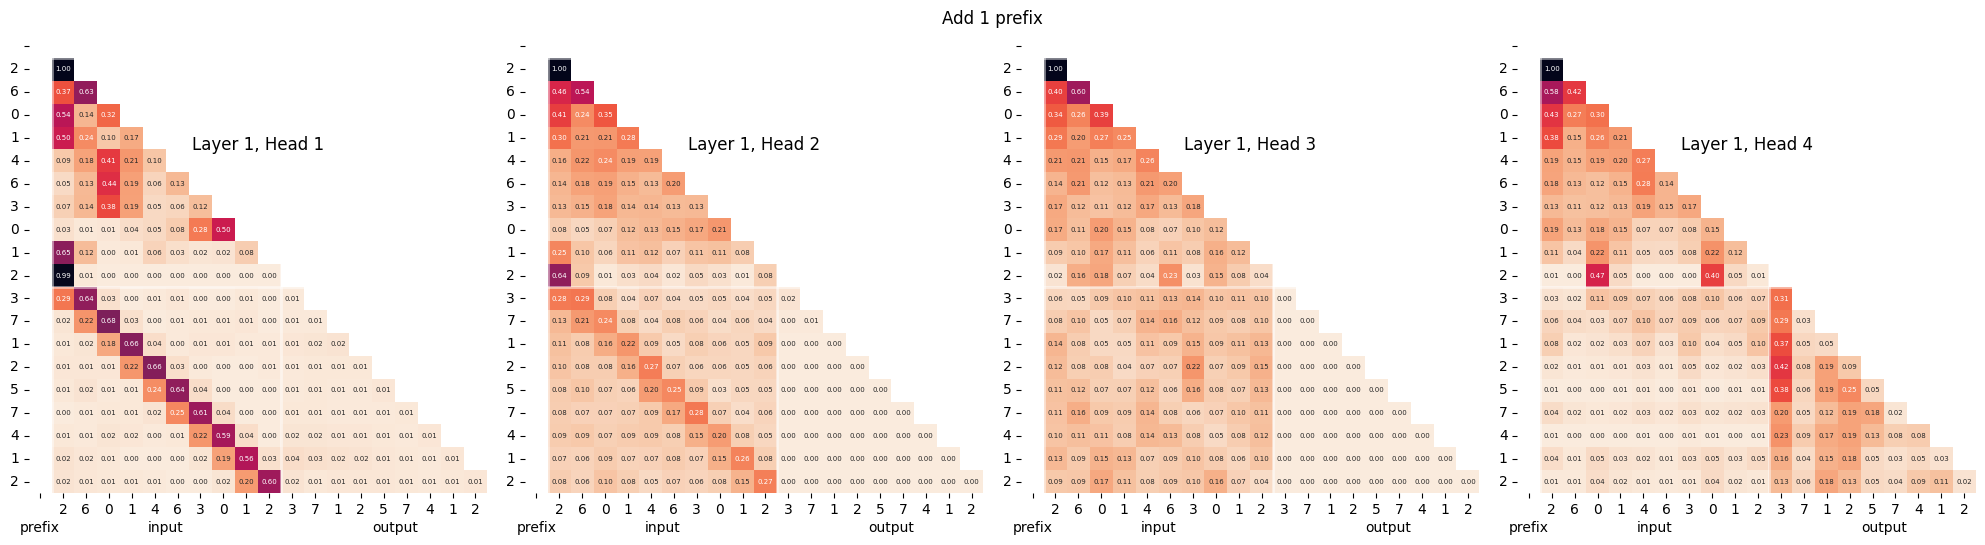

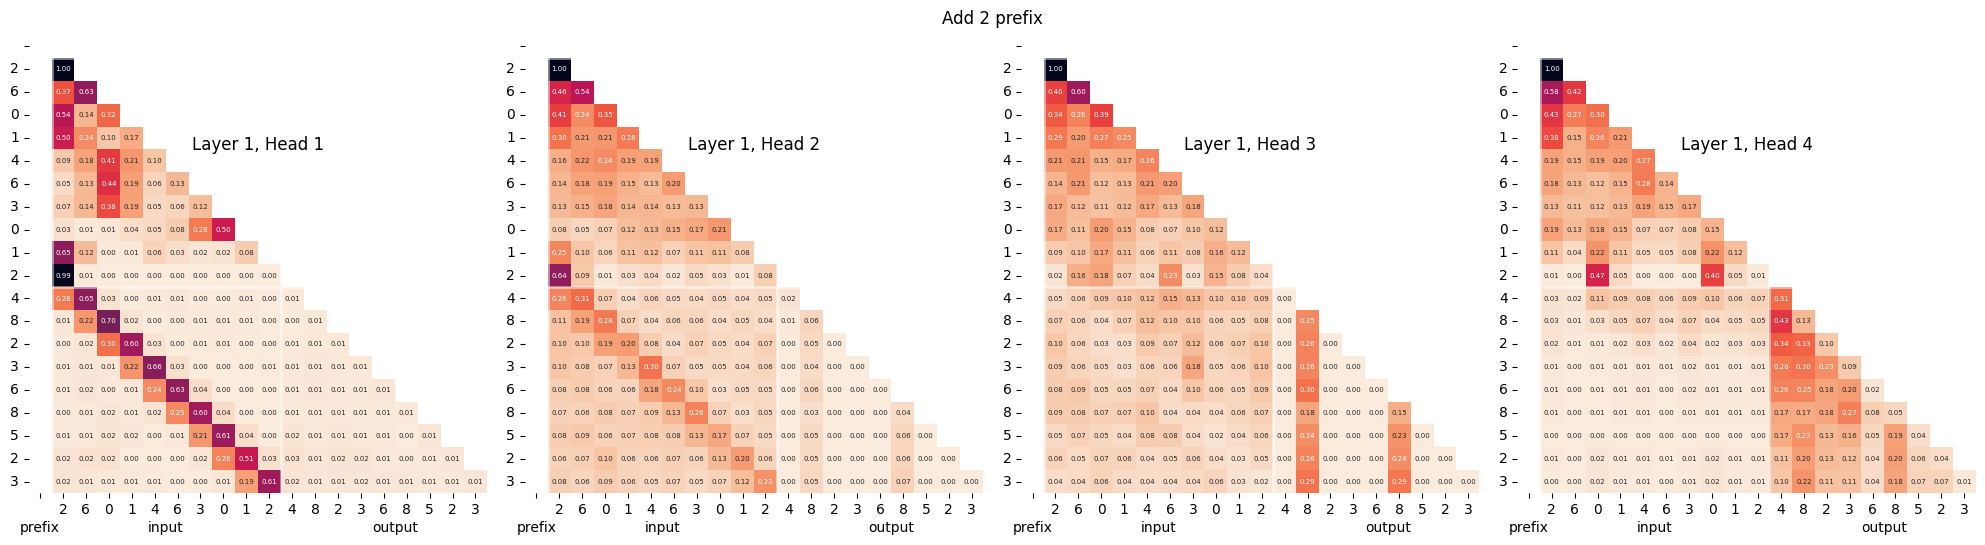

In [8]:
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=None)
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Pre-trained", ignore_and_rescale_prefix=True)
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["ascending"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Ascending prefix", ignore_and_rescale_prefix=True)
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["descending"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Descending prefix", ignore_and_rescale_prefix=True)
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["add1"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Add 1 prefix", ignore_and_rescale_prefix=True)
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes["add2"])
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_random.length, title="Add 2 prefix", ignore_and_rescale_prefix=True)

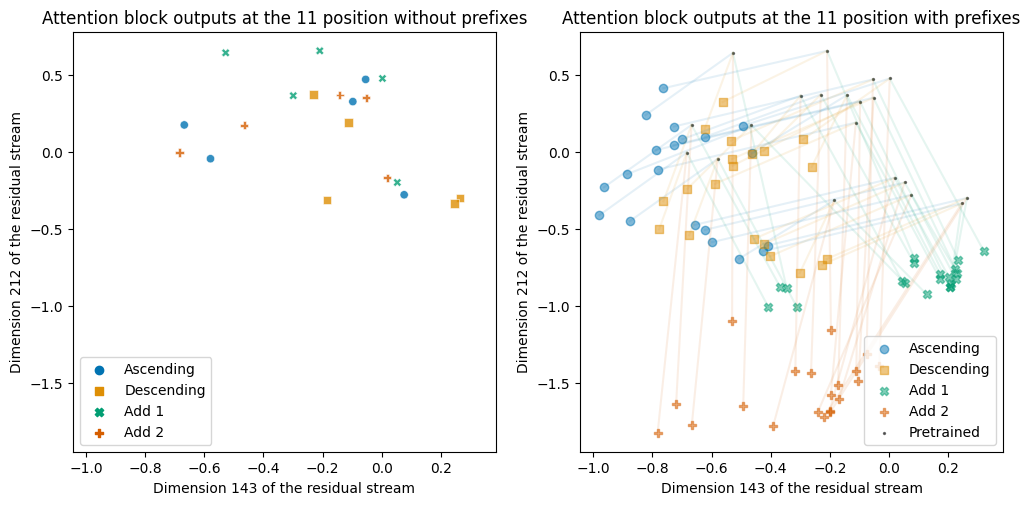

In [9]:
batch = torch.stack([torch.vstack(train_dataset_random[i])  for i in range(20)], dim=0).to(device)
batch_x, batch_y = [t.squeeze() for t in batch.split(1, dim=1)]

colors = sns.color_palette("colorblind", 4)
markers = ["o", "s", "X", "P"]
label_to_idx = {"Ascending": 0, "Descending": 1, "Add 1": 2, "Add 2": 3}

record = []
_ = model(batch_x, activations_record=record, prefixes=None)
r_pretrained = torch.stack([a[1] for a in record if a[0]=="attn_block_output"], dim=0)
record = []
_ = model(batch_x, activations_record=record, prefixes=prefixes["ascending"])
r_ascending = torch.stack([a[1] for a in record if a[0]=="attn_block_output"], dim=0)
record = []
_ = model(batch_x, activations_record=record, prefixes=prefixes["descending"])
r_descending = torch.stack([a[1] for a in record if a[0]=="attn_block_output"], dim=0)
record = []
_ = model(batch_x, activations_record=record, prefixes=prefixes["add1"])
r_add1 = torch.stack([a[1] for a in record if a[0]=="attn_block_output"], dim=0)
record = []
_ = model(batch_x, activations_record=record, prefixes=prefixes["add2"])
r_add2 = torch.stack([a[1] for a in record if a[0]=="attn_block_output"], dim=0)

all_labels = ["Ascending"] * len(batch_x) + ["Descending"] * len(batch_x) + ["Add 1"] * len(batch_x) + ["Add 2"] * len(batch_x)

indexes = torch.randint(0,253,size=(2,))
layer_id = 0
pos = prefix_size + train_dataset_random.length - 1
plt.figure(figsize=(12, 12))
A=torch.vstack([
    r_ascending[layer_id,:,pos,indexes],
    r_descending[layer_id,:,pos,indexes],
    r_add1[layer_id,:,pos,indexes],
    r_add2[layer_id,:,pos,indexes],
])

A_wo_prefix = r_pretrained[layer_id,:,pos,indexes]

plt.subplot(2, 2, 1)
labels = label_batch(batch_x, batch_y, prefix_size=prefix_size, length=train_dataset_random.length)
_colors = {l: colors[label_to_idx[l]] for l in labels}
_markers = {l: markers[label_to_idx[l]] for l in labels}
sns.scatterplot(x=A_wo_prefix[:,0], y=A_wo_prefix[:, 1], alpha=0.8, hue=labels, markers=_markers, palette=_colors, style=labels)
plt.title(f"Attention block outputs at the {pos+1} position without prefixes")
plt.xlabel(f"Dimension {indexes[0].item()} of the residual stream")
plt.ylabel(f"Dimension {indexes[1].item()} of the residual stream")

plt.subplot(2, 2, 2)
plt.title(f"Attention block outputs at the {pos+1} position with prefixes")
plt.xlabel(f"Dimension {indexes[0].item()} of the residual stream")
plt.ylabel(f"Dimension {indexes[1].item()} of the residual stream")

plt.scatter(r_ascending[layer_id,:,pos,indexes[0]], r_ascending[layer_id,:,pos,indexes[1]], alpha=0.5, label="Ascending", color=_colors["Ascending"], marker=_markers["Ascending"])
plt.scatter(r_descending[layer_id,:,pos,indexes[0]], r_descending[layer_id,:,pos,indexes[1]], alpha=0.5, label="Descending", color=_colors["Descending"], marker=_markers["Descending"])
plt.scatter(r_add1[layer_id,:,pos,indexes[0]], r_add1[layer_id,:,pos,indexes[1]], alpha=0.5, label="Add 1", color=_colors["Add 1"], marker=_markers["Add 1"])
plt.scatter(r_add2[layer_id,:,pos,indexes[0]], r_add2[layer_id,:,pos,indexes[1]], alpha=0.5, label="Add 2", color=_colors["Add 2"], marker=_markers["Add 2"])

plt.scatter(r_pretrained[layer_id,:,pos,indexes[0]], r_pretrained[layer_id,:,pos,indexes[1]], alpha=0.5, label="Pretrained", color="k", s=2)
for i in range(len(batch_x)):
    plt.plot([r_ascending[layer_id,i,pos,indexes[0]], r_pretrained[layer_id,i,pos,indexes[0]]], [r_ascending[layer_id,i,pos,indexes[1]], r_pretrained[layer_id,i,pos,indexes[1]]], color=_colors["Ascending"], alpha=0.1)
    plt.plot([r_descending[layer_id,i,pos,indexes[0]], r_pretrained[layer_id,i,pos,indexes[0]]], [r_descending[layer_id,i,pos,indexes[1]], r_pretrained[layer_id,i,pos,indexes[1]]], color=_colors["Descending"], alpha=0.1)
    plt.plot([r_add1[layer_id,i,pos,indexes[0]], r_pretrained[layer_id,i,pos,indexes[0]]], [r_add1[layer_id,i,pos,indexes[1]], r_pretrained[layer_id,i,pos,indexes[1]]], color=_colors["Add 1"], alpha=0.1)
    plt.plot([r_add2[layer_id,i,pos,indexes[0]], r_pretrained[layer_id,i,pos,indexes[0]]], [r_add2[layer_id,i,pos,indexes[1]], r_pretrained[layer_id,i,pos,indexes[1]]], color=_colors["Add 2"], alpha=0.1)

plt.legend()

xlims = []
ylims = []
for ax in plt.gcf().axes:
    xlims.append(ax.get_xlim())
    ylims.append(ax.get_ylim())
xlims = (min([x[0] for x in xlims]), max([x[1] for x in xlims]))
ylims = (min([x[0] for x in ylims]), max([x[1] for x in ylims]))
for ax in plt.gcf().axes:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

plt.savefig("02_compare_with_wo_prefix.pdf")